In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torchaudio import transforms
from torchaudio import transforms as T
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

cuda


In [2]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, sample_rate=22050, duration=2.0, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.sample_rate = sample_rate
        self.duration = duration
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.file_paths[idx])
        # Ensure consistent duration by padding or trimming
        target_length = int(self.sample_rate * self.duration)
        if waveform.size(1) < target_length:
            waveform = torch.nn.functional.pad(waveform, (0, target_length - waveform.size(1)))
        else:
            waveform = waveform[:, :target_length]
        if self.transform:
            spectrogram = self.transform(waveform)
        else:
            spectrogram = waveform  # Fallback, though we’ll use transforms
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return spectrogram, label

# Helper function to load file paths and labels
def load_data_from_folders(real_folder, fake_folder):
    file_paths = []
    labels = []
    # Real audio
    for file_name in os.listdir(real_folder):
        if file_name.endswith('.wav'):
            file_paths.append(os.path.join(real_folder, file_name))
            labels.append(1)  # 1 for real
    # Fake audio
    for file_name in os.listdir(fake_folder):
        if file_name.endswith('.wav'):
            file_paths.append(os.path.join(fake_folder, file_name))
            labels.append(0)  # 0 for fake
    return file_paths, labels

# Load data
root = "datasets/release_in_the_wild"
real_folder = os.path.join(root, "real")
fake_folder = os.path.join(root, "fake")
file_paths, labels = load_data_from_folders(real_folder, fake_folder)

/home/rahi/miniconda3/envs/vit/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


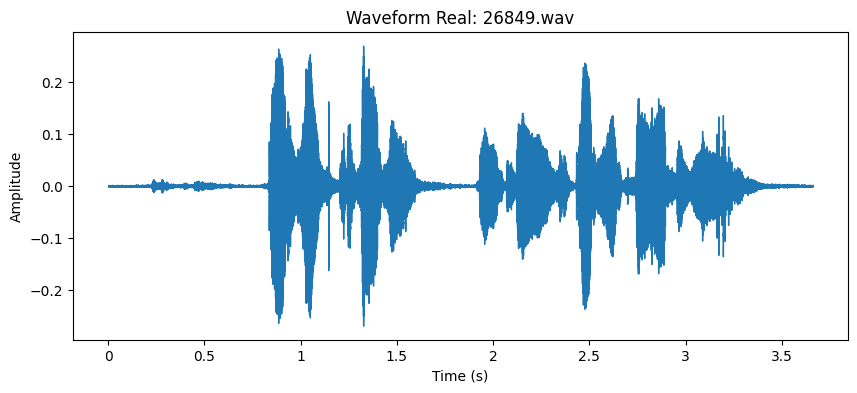

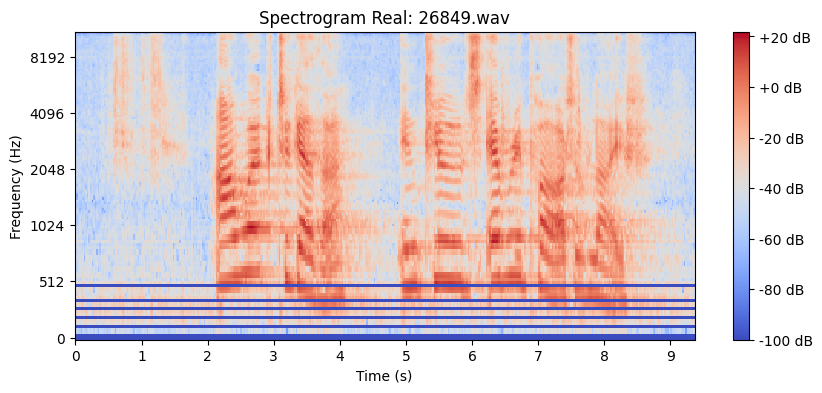

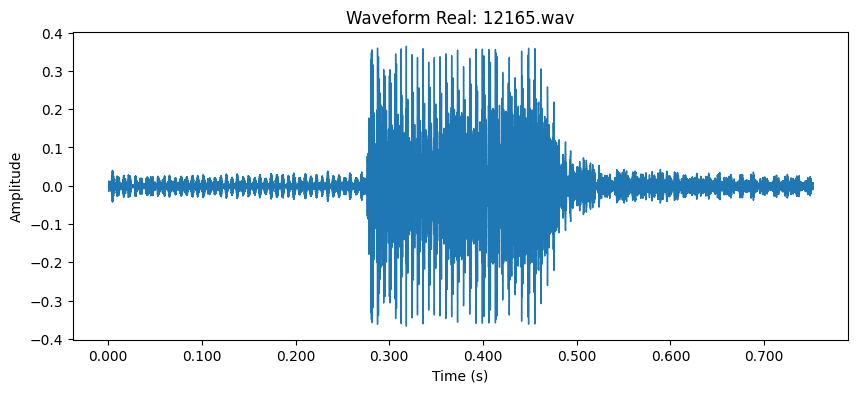

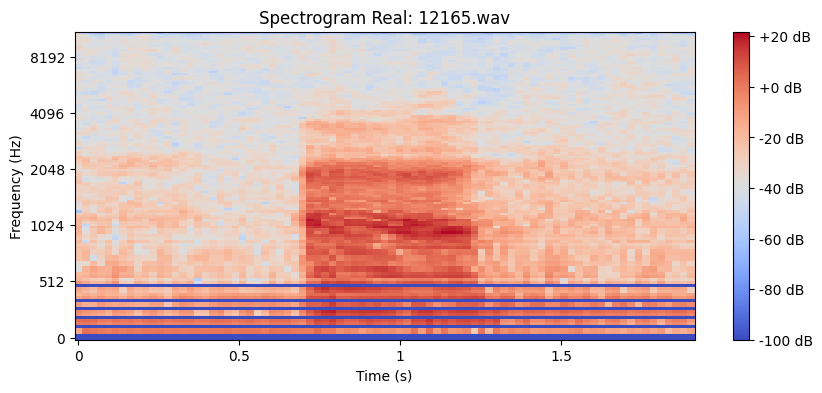

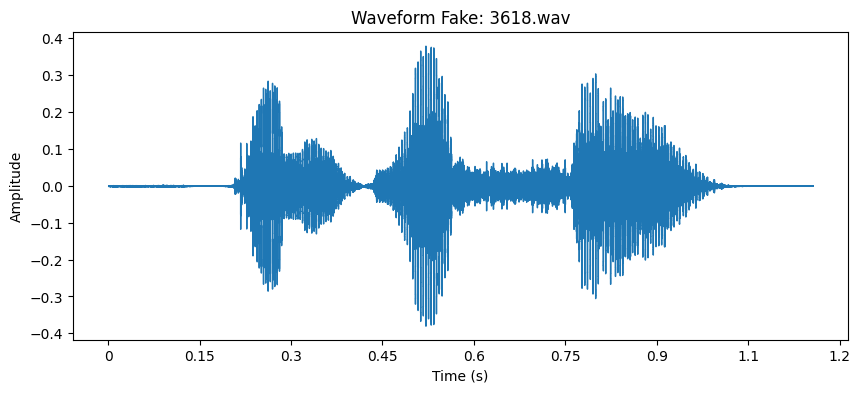

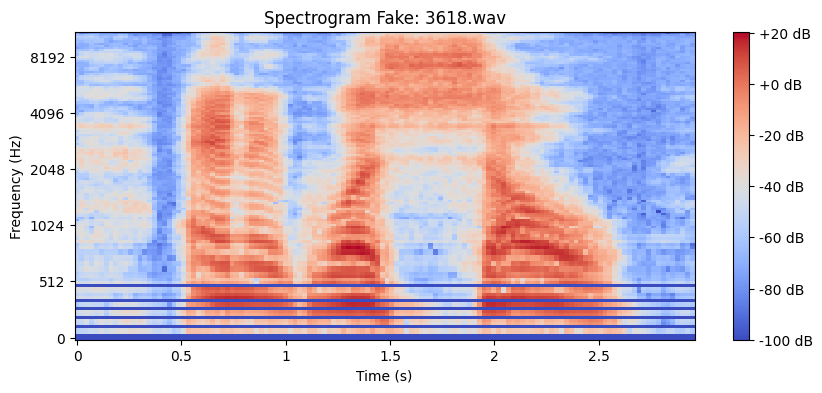

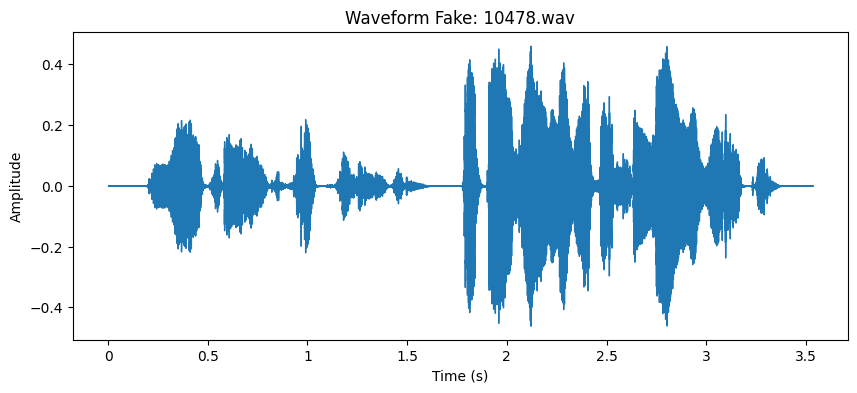

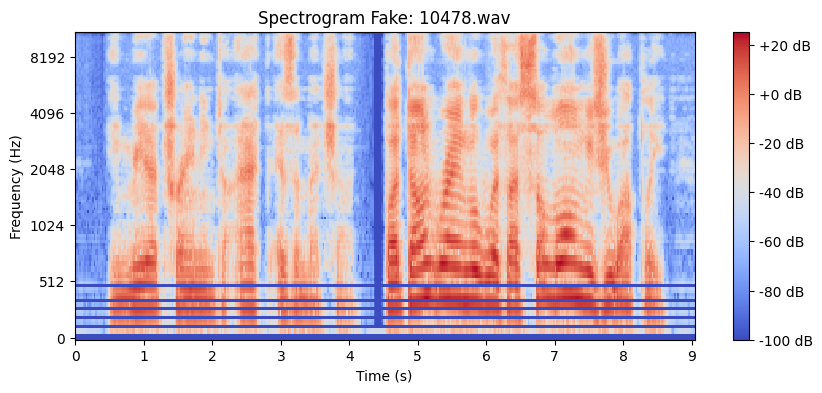

In [3]:
def visualize_waveform(waveform, sr, title):
    waveform = waveform.numpy().squeeze()  # Convert tensor to numpy
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def visualize_spectrogram(spectrogram, sr, title):
    spectrogram = spectrogram.numpy().squeeze()  # Convert tensor to numpy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

# Example visualization
sample_transform = T.MelSpectrogram(sample_rate=22050, n_mels=128)
for i in range(2):  # First two real and fake
    waveform, _ = torchaudio.load(file_paths[i])
    visualize_waveform(waveform, 22050, f"Waveform Real: {os.path.basename(file_paths[i])}")
    spectrogram = sample_transform(waveform)
    spectrogram_db = T.AmplitudeToDB()(spectrogram)
    visualize_spectrogram(spectrogram_db, 22050, f"Spectrogram Real: {os.path.basename(file_paths[i])}")
for i in range(len(file_paths) - 2, len(file_paths)):  # Last two (assuming fake at end)
    waveform, _ = torchaudio.load(file_paths[i])
    visualize_waveform(waveform, 22050, f"Waveform Fake: {os.path.basename(file_paths[i])}")
    spectrogram = sample_transform(waveform)
    spectrogram_db = T.AmplitudeToDB()(spectrogram)
    visualize_spectrogram(spectrogram_db, 22050, f"Spectrogram Fake: {os.path.basename(file_paths[i])}")

In [4]:
transform = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=22050, n_mels=128, n_fft=1024, hop_length=512),
    transforms.AmplitudeToDB()
)

# Split data
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=38, stratify=labels
)

# Create datasets
train_dataset = AudioDataset(train_paths, train_labels, transform=transform)
test_dataset = AudioDataset(test_paths, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Cell 5 (Updated): Define CNN Model
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 10, 256)  # Corrected from 22528 to 20480
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize model
model = AudioCNN().to(device)
# Model summary
print(model)
# models parameters count
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20480, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)
Total parameters: 5336513


In [6]:
# Cell 4: Training and Evaluation Functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap data_loader with tqdm for progress bar
    loop = tqdm(data_loader, desc="Training", leave=False)
    for spectrograms, labels in loop:
        spectrograms, labels = spectrograms.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm postfix with current loss
        loop.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap data_loader with tqdm for progress bar
    loop = tqdm(data_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for spectrograms, labels in loop:
            spectrograms, labels = spectrograms.to(device), labels.to(device).unsqueeze(1)
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loop.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, train_accs, val_losses, val_accs

In [7]:
# Cell 5: Train the Model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 10

train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/10:
  Train Loss: 0.1787, Train Acc: 0.9782
  Val Loss: 0.0189, Val Acc: 0.9948


Epoch 2/10:
  Train Loss: 0.0337, Train Acc: 0.9904
  Val Loss: 0.0224, Val Acc: 0.9924


Epoch 3/10:
  Train Loss: 0.0356, Train Acc: 0.9920
  Val Loss: 0.0166, Val Acc: 0.9956


Epoch 4/10:
  Train Loss: 0.0308, Train Acc: 0.9916
  Val Loss: 0.0169, Val Acc: 0.9956


Epoch 5/10:
  Train Loss: 0.0228, Train Acc: 0.9937
  Val Loss: 0.0239, Val Acc: 0.9935


Epoch 6/10:
  Train Loss: 0.0227, Train Acc: 0.9942
  Val Loss: 0.0141, Val Acc: 0.9964


Epoch 7/10:
  Train Loss: 0.0177, Train Acc: 0.9950
  Val Loss: 0.0229, Val Acc: 0.9961


Epoch 8/10:
  Train Loss: 0.0157, Train Acc: 0.9962
  Val Loss: 0.0087, Val Acc: 0.9973


Epoch 9/10:
  Train Loss: 0.0136, Train Acc: 0.9962
  Val Loss: 0.0049, Val Acc: 0.9986


Epoch 10/10:
  Train Loss: 0.0116, Train Acc: 0.9966
  Val Loss: 0.0160, Val Acc: 0.9967


In [8]:
# Cell 7: Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        predicted = (outputs > 0.5).float().squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9967


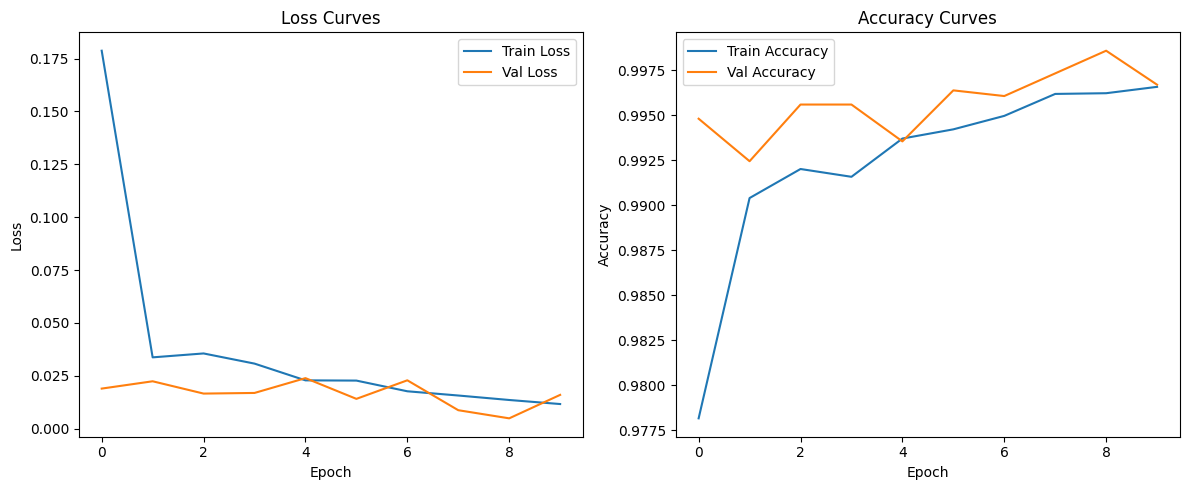

In [9]:
# Cell 6: Plotting Results
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Cell 8: Inference Function
def perform_inference(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Progress bar for inference
    loop = tqdm(data_loader, desc="Inference", leave=False)
    with torch.no_grad():
        for spectrograms, labels in loop:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            
            # Probabilities (sigmoid output)
            probs = outputs.squeeze().cpu().numpy()
            # Binary predictions
            preds = (outputs > 0.5).float().squeeze().cpu().numpy()
            # True labels
            labels = labels.cpu().numpy()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Convert to numpy arrays for sklearn metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return {
        'predictions': all_preds,
        'probabilities': all_probs,
        'labels': all_labels,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

# Run inference on test dataset
results = perform_inference(model, test_loader, device)

# Print results
print("Inference Results on Test Dataset:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1-Score: {results['f1_score']:.4f}")
print("\nConfusion Matrix:")
print(results['confusion_matrix'])

Inference Results on Test Dataset:
Accuracy: 0.9967
Precision: 0.9948
Recall: 1.0000
F1-Score: 0.9974

Confusion Matrix:
[[2342   21]
 [   0 3993]]


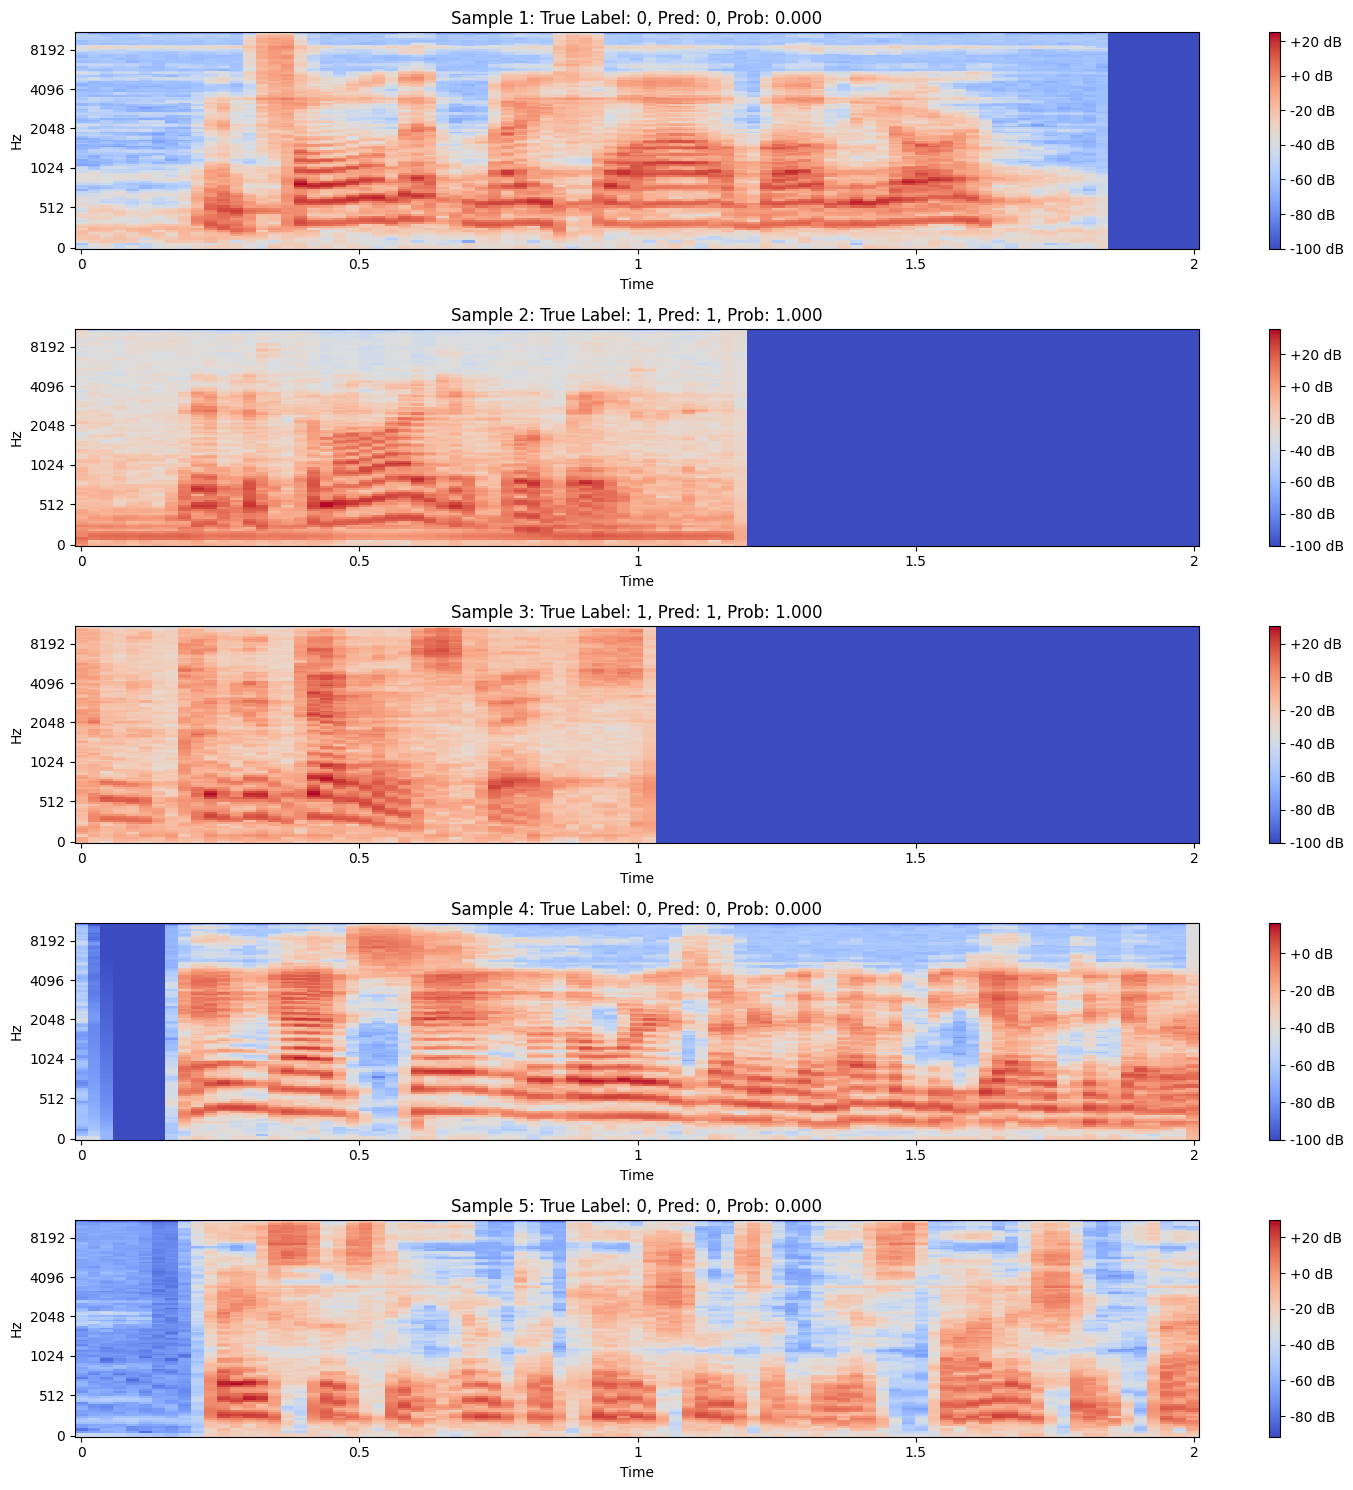

In [11]:
# Cell 9: Visualize Sample Predictions
def visualize_predictions(test_loader, results, num_samples=5):
    model.eval()
    spectrograms_list = []
    labels_list = []
    preds_list = []
    probs_list = []
    
    # Collect samples
    with torch.no_grad():
        for i, (spectrograms, labels) in enumerate(test_loader):
            spectrograms = spectrograms.to(device)
            outputs = model(spectrograms)
            preds = (outputs > 0.5).float().squeeze().cpu().numpy()
            probs = outputs.squeeze().cpu().numpy()
            
            spectrograms_list.extend(spectrograms.cpu().numpy())
            labels_list.extend(labels.numpy())
            preds_list.extend(preds)
            probs_list.extend(probs)
            if len(labels_list) >= num_samples:
                break
    
    # Plot
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(min(num_samples, len(labels_list))):
        plt.subplot(num_samples, 1, i + 1)
        spectrogram = spectrograms_list[i][0]  # Remove channel dim
        librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Sample {i+1}: True Label: {int(labels_list[i])}, Pred: {int(preds_list[i])}, Prob: {probs_list[i]:.3f}")
    plt.tight_layout()
    plt.show()

# Visualize 5 test samples
visualize_predictions(test_loader, results, num_samples=5)

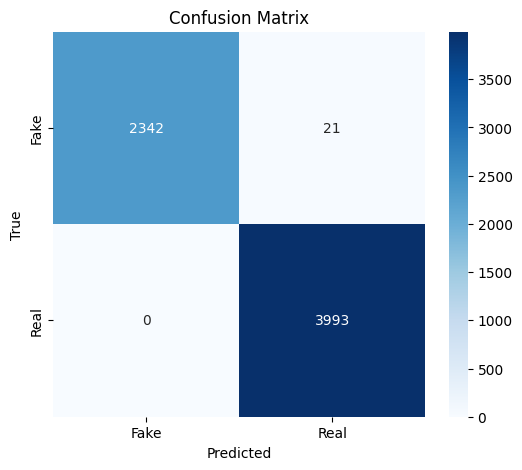

In [12]:
# Cell 10: Confusion Matrix Visualization


plt.figure(figsize=(6, 5))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

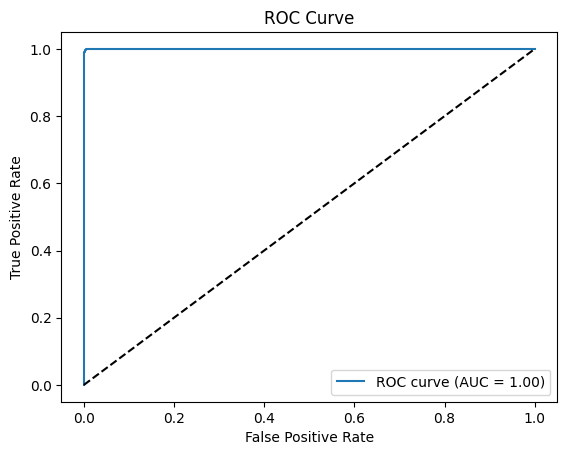

In [13]:

fpr, tpr, _ = roc_curve(results['labels'], results['probabilities'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Save the model

In [14]:
# Save the model wih both weights and architecture
# torch.save(model, 'models/audio_deep_fake_cnn.pth')
torch.save(model.state_dict(), 'models/audio_deep_fake_cnn_states.pth')

## Load the saved model

In [15]:
model2 = AudioCNN().to(device)
model2.load_state_dict(torch.load('models/audio_deep_fake_cnn_states.pth'))
model2.eval()
# model2 = torch.load('models/audio_deep_fake_cnn.pth')
results2 = perform_inference(model2, test_loader, device)
print("Results from loaded model:")
print(f"Accuracy: {results2['accuracy']:.4f}")
print(f"Precision: {results2['precision']:.4f}")
print(f"Recall: {results2['recall']:.4f}")
print(f"F1-Score: {results2['f1_score']:.4f}")
print("\nConfusion Matrix:")
print(results2['confusion_matrix'])


/tmp/ipykernel_76192/2155551264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('models/audio_deep_fake_cnn_states.pth'))
             

Results from loaded model:
Accuracy: 0.9967
Precision: 0.9948
Recall: 1.0000
F1-Score: 0.9974

Confusion Matrix:
[[2342   21]
 [   0 3993]]
